In [ ]:
using LinearAlgebra
using Plots
using Printf
using SparseArrays

# **Hubbard model Exact Diagonalization (Considering System symmetry)**

In [ ]:
function Hubbard_ED(n)
    ###############
    # Parameters
    ###############
    
    N = n; # Number of spins
    t = 1 #Hopping term
    mu = 0.1 #On-site term
    
    sigma_z = [1 0;0 -1];
    sigma_m = [0 0; 1 0];
    I_d = [1 0 ; 0 1]; 
    sigma_z = sparse(sigma_z)
    sigma_m = sparse(sigma_m)
    I_d = sparse(I_d)
    Z = Dict() 
    C = Dict() #C is annihilation opperator and C_dagger is creation operator
    Id = Dict()

    Z[1] = sigma_z
    Id[1] = I_d

    #####################################
    #   Construction of Spin operators
    #####################################

    t_operators = @elapsed begin
    for i=2:N-1
        Z[i] = kron(sigma_z,Z[i-1])
        Id[i] = Matrix(I, 2^i, 2^i)
    end
    Id[N] =  Matrix(I, 2^N, 2^N)
    for i=1:N
        if i!=1 && i!=N
            C[i] = kron(kron(Z[i-1],sigma_m),Id[N-i])
        end
        if i==1
            C[i] = kron(sigma_m,Id[N-i])
        end
        if i==N
            C[i] = kron(Z[i-1],sigma_m)
        end
    end
    end

    #################################################################### 
    #   Construction of Many-body Hamiltonian matrix & Number operator
    ####################################################################

    sum_time  = @elapsed begin
    Num_op = spzeros(2^N, 2^N) #Number operator
    Num_op = C[N]'C[N]
    
    H = spzeros(2^N, 2^N) #Hamiltonian
    #Imposing PBC
    H = - mu*(C[N]'*C[N])*((-1)^N) -t*(C[N]'C[1]+ C[1]'*C[N]);
    
    #Sum over all sites:
    for i=1:N-1
        H  = -t * (C[i+1]'*C[i] + C[i]'*C[i+1]) - mu*(C[i]'*C[i])*((-1)^i) + H
        Num_op = C[i]'C[i] + Num_op
    end
    H = (H + H')/2; #Making sure Hamiltonian is hermitian
    end

    ###############
    # First method:                                
    ########################################################
    # Exact digonalization for the entire Hamiltonian matrix
    ########################################################

    total_diag_time = @elapsed begin
    Energy, State = eigen(Matrix(H));
    Energy = sort(Energy) #Energy spectrum from first method 
    end

    #################################################################################################################
    #   Sorting Num_op and Permuting Hamiltonian with sorted indices (Using System Symmetry to block diagonalize H)
    #################################################################################################################

    transformation_time = @elapsed begin
    Num_op_diag = diag(Num_op);
    Num_op_sorted = sort(Num_op_diag);
    s2 = sortperm(Num_op_diag); #indices after sorting Num_op_diag
    
    U = spzeros(2^N, 2^N) # U is Transformation matrix
    for i=1:2^N
        U[s2[i], i] = 1
    end
    #Basis Transformation:
    H_sorted = U'*H*U; # H_sorted = U_dagger*H*U
    end

    ########################
    # Block diagonalization
    ########################

    block_diag_time = @elapsed begin
    #Calculating size of each block by counting how many times each number is repeated in Num_op 
    u = (unique(Num_op_sorted))
    d = Dict([(i,count(x->x==i,Num_op_sorted)) for i in u])
    
    d_new = zeros(N+1);
    c = 1
    for i in u
        d_new[c] = (d[i])
        c=c+1
    end
    pop!(d_new)
    popfirst!(d_new)
    
    first = 2
    Energy_Block_Diag = [] #Energy spectrum from second method (ED for block diagonalized H)
    
    for i in d_new
        last = first + Int(i) -1
        En_BD,S_BD  = eigen(Matrix(H_sorted[first:last,first:last]))
        append!(Energy_Block_Diag, En_BD)
        first = last + 1
    end
    
    #the first and last elements in H_sorted are single numbers
    append!(Energy_Block_Diag, H_sorted[1,1])
    append!(Energy_Block_Diag, H_sorted[2^N,2^N])
    Energy_Block_Diag = sort(Energy_Block_Diag)
    end

    ####################
    # Calculating Time
    ####################
    First_Time =  t_operators + sum_time + total_diag_time
    Second_Time = t_operators + sum_time + transformation_time + block_diag_time

    return Energy_Block_Diag, Energy, H_sorted, First_Time,Second_Time
end

Hubbard_ED (generic function with 1 method)

# N = 8

In [ ]:
En_BD8, En8, H_sorted8, block_diag_time8, total_diag_time8 = Hubbard_ED(8);

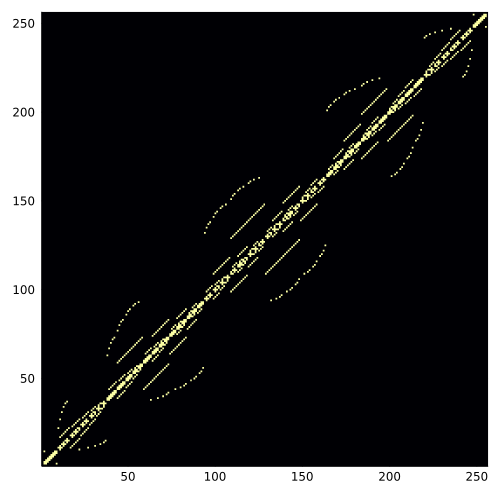

In [ ]:
H_plot8 = Matrix(H_sorted8)
H_plot8[H_plot8.!=0] .=1;
heatmap(H_plot8,legend = false,size = (500, 500))

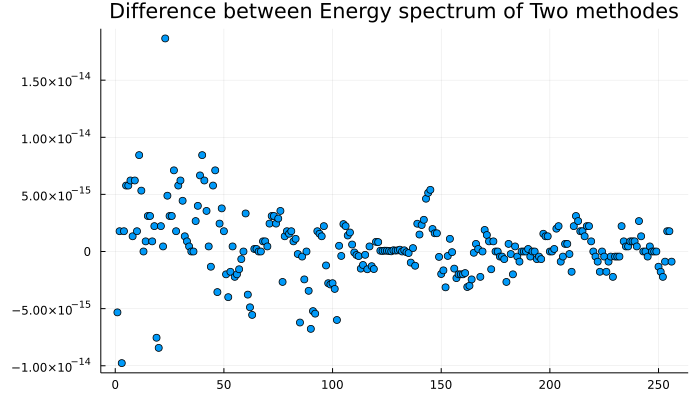

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference8 = (En_BD8 - En8)
scatter(Difference8 ,legend = false,size = (700, 400))
title!("Difference between Energy spectrum of Two methodes")

In [ ]:
@printf("After Taking sum over the entire spectrum the Difference between two methodes is %s",sum(Difference8))

After Taking sum over the entire spectrum the Difference between two methodes is 1.102896634562806e-13

In [ ]:
# Comparind Energy values of two methods (true if they are equal)
En_BD8 ≈ En8

true

In [ ]:
Time_difference8 = (total_diag_time8 - block_diag_time8) 
@printf("conserved time is %s", Time_difference8)

conserved time is 0.08024293300000002

In [ ]:
Ground_state1 = En8[1]
Ground_state2 = En_BD8[1]
@printf("Ground state Energy in first method = %s \n" , Ground_state1)
@printf("Ground state Energy in first method = %s  " ,Ground_state2)

Ground state Energy in first method = -4.937987815201638 
Ground state Energy in first method = -4.937987815201644  

# N = 12

In [ ]:
En_BD12, En12, H_sorted12, block_diag_time12, total_diag_time12 = Hubbard_ED(12);

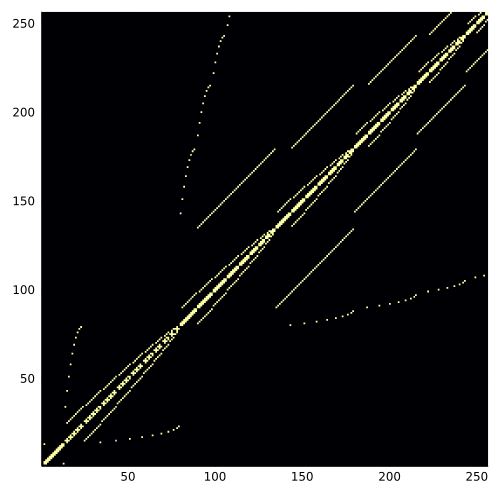

In [ ]:
H_plot12 = Matrix(H_sorted12)
H_plot12[H_plot12.!=0] .=1;
heatmap(H_plot12[1:256,1:256],legend = false,size = (500, 500))

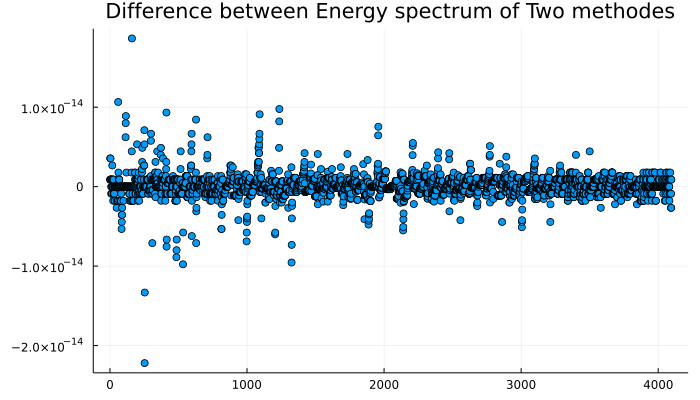

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference12 = (En_BD12 - En12)
scatter(Difference12 ,legend = false,size = (700, 400))
title!("Difference between Energy spectrum of Two methodes")

In [ ]:
@printf("After Taking sum over the entire spectrum the Difference between two methodes is %s",sum(Difference12))

After Taking sum over the entire spectrum the Difference between two methodes is 3.5637223801177626e-13

In [ ]:
# Comparing Energy values of two methods (true if they are equal)
En_BD12 ≈ En12

true

In [ ]:
Time_difference12 = -(total_diag_time12 - block_diag_time12) 
@printf("conserved time is %s", Time_difference12)

conserved time is 18.697956343999998

In [ ]:
Ground_state1 = En12[1]
Ground_state2 = En_BD12[1]
@printf("Ground state Energy in first method = %s \n" , Ground_state1)
@printf("Ground state Energy in first method = %s  " ,Ground_state2)

Ground state Energy in first method = -7.582343878253751 
Ground state Energy in first method = -7.5823438782537504  